# Using a pre-trained convnet

This notebook contains the code sample found in Chapter 5, Section 3 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

A common and highly effective approach to deep learning on small image datasets is to leverage a pre-trained network. A pre-trained network 
is simply a saved network previously trained on a large dataset, typically on a large-scale image classification task. If this original 
dataset is large enough and general enough, then the spatial feature hierarchy learned by the pre-trained network can effectively act as a 
generic model of our visual world, and hence its features can prove useful for many different computer vision problems, even though these 
new problems might involve completely different classes from those of the original task. For instance, one might train a network on 
ImageNet (where classes are mostly animals and everyday objects) and then re-purpose this trained network for something as remote as 
identifying furniture items in images. Such portability of learned features across different problems is a key advantage of deep learning 
compared to many older shallow learning approaches, and it makes deep learning very effective for small-data problems.

In our case, we will consider a large convnet trained on the ImageNet dataset (1.4 million labeled images and 1000 different classes). 
ImageNet contains many animal classes, including different species of cats and dogs, and we can thus expect to perform very well on our cat 
vs. dog classification problem.

We will use the VGG16 architecture, developed by Karen Simonyan and Andrew Zisserman in 2014, a simple and widely used convnet architecture 
for ImageNet. Although it is a bit of an older model, far from the current state of the art and somewhat heavier than many other recent 
models, we chose it because its architecture is similar to what you are already familiar with, and easy to understand without introducing 
any new concepts. This may be your first encounter with one of these cutesie model names -- VGG, ResNet, Inception, Inception-ResNet, 
Xception... you will get used to them, as they will come up frequently if you keep doing deep learning for computer vision.

There are two ways to leverage a pre-trained network: *feature extraction* and *fine-tuning*. We will cover both of them. Let's start with 
feature extraction.

#### Requirements
USING PYTHON VERSION OF >=3.7, <=3.10

For GPU (CUDA 11.7): `conda install pytorch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0 pytorch-cuda=11.7 -c pytorch -c nvidia`

For CPU: `conda install pytorch==1.13.0 torchvision==0.14.0 torchaudio==0.13.0 cpuonly -c pytorch`

`pip install torchtext==0.14.0`

`pip install torchdata==0.5.0`

`pip install matplotlib`

`pip install ipykernel`

`conda install -c anaconda pandas`

`conda install -c anaconda scikit-learn`

newly added: `pip install torchsummary`


Reference for installing PyTorch: https://pytorch.org/get-started/previous-versions/#linux-and-windows-4

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. 
These features are then run through a new classifier, which is trained from scratch.

As we saw previously, convnets used for image classification comprise two parts: they start with a series of pooling and convolution 
layers, and they end with a densely-connected classifier. The first part is called the "convolutional base" of the model. In the case of 
convnets, "feature extraction" will simply consist of taking the convolutional base of a previously-trained network, running the new data 
through it, and training a new classifier on top of the output.

![swapping FC classifiers](https://s3.amazonaws.com/book.keras.io/img/ch5/swapping_fc_classifier.png)

Why only reuse the convolutional base? Could we reuse the densely-connected classifier as well? In general, it should be avoided. The 
reason is simply that the representations learned by the convolutional base are likely to be more generic and therefore more reusable: the 
feature maps of a convnet are presence maps of generic concepts over a picture, which is likely to be useful regardless of the computer 
vision problem at hand. On the other end, the representations learned by the classifier will necessarily be very specific to the set of 
classes that the model was trained on -- they will only contain information about the presence probability of this or that class in the 
entire picture. Additionally, representations found in densely-connected layers no longer contain any information about _where_ objects are 
located in the input image: these layers get rid of the notion of space, whereas the object location is still described by convolutional 
feature maps. For problems where object location matters, densely-connected features would be largely useless.

Note that the level of generality (and therefore reusability) of the representations extracted by specific convolution layers depends on 
the depth of the layer in the model. Layers that come earlier in the model extract local, highly generic feature maps (such as visual 
edges, colors, and textures), while layers higher-up extract more abstract concepts (such as "cat ear" or "dog eye"). So if your new 
dataset differs a lot from the dataset that the original model was trained on, you may be better off using only the first few layers of the 
model to do feature extraction, rather than using the entire convolutional base.

In our case, since the ImageNet class set did contain multiple dog and cat classes, it is likely that it would be beneficial to reuse the 
information contained in the densely-connected layers of the original model. However, we will chose not to, in order to cover the more 
general case where the class set of the new problem does not overlap with the class set of the original model.

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet, to extract interesting features from 
our cat and dog images, and then training a cat vs. dog classifier on top of these features.

The VGG16 model, among others, comes pre-packaged with Keras. You can import it from the `keras.applications` module. Here's the list of 
image classification models (all pre-trained on the ImageNet dataset) that are available as part of `keras.applications`:

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

Let's instantiate the VGG16 model:

In [ ]:
import torchvision.models as models 
from torchsummary import summary
import torch
vgg16 = models.vgg16(pretrained=True).cuda()

If "pretrained" is True, returns a model pre-trained on ImageNet

In [4]:
output = vgg16(torch.zeros(8, 3, 150, 150).cuda())
print(output.shape)

torch.Size([8, 1000])


Modify last layer in classifier to use the model for binary classification

In [5]:
num_classes = 2
vgg16.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=num_classes, bias=True)

In [6]:
vgg16.cuda()
output = vgg16(torch.zeros(8, 3, 150, 150).cuda())
print(output.shape)

torch.Size([8, 2])


In [7]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
summary(vgg16, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,

In [9]:
import torch 
from PIL import Image 
import numpy as np 
import os 
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn 
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random 
import shutil 
import argparse 
from tqdm import tqdm

In [10]:
feature_extractor = vgg16.features
input_tensor = torch.zeros((8, 3, 150, 150)).cuda()
features = feature_extractor(input_tensor) 
print(features.shape)

torch.Size([8, 512, 4, 4])


### Download Dataset
Download the dataset from https://www.kaggle.com/c/dogs-vs-cats/data

Please makesure the dataset is in the same directory as this notebook. The directory structure should be as follows:

`.data/datasets/dogs-vs-cats/train`

`.data/datasets/dogs-vs-cats/val`


### Custom Dataset

In [43]:
class CustomDataset(Dataset):
    def __init__(self, phase):
        self.phase = phase 
        # self.data_root = 'data/datasets/dogs-vs-cats'
        self.data_root = os.path.abspath('data/datasets/dogs-vs-cats')
        self.data_path = os.path.join(self.data_root, self.phase)
        self.data_list = os.listdir(self.data_path)
    
        self.train_trans = transforms.Compose([
                                transforms.Resize((256,256)),
                                transforms.RandomHorizontalFlip(), 
                                transforms.RandomCrop(224),
                                transforms.ToTensor(),]) 
        self.val_trans = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),])
        
        
        
    def __len__(self):
        return len(self.data_list)
    
    
    def __getitem__(self, idx):
        filename = os.path.join(self.data_path, self.data_list[idx])
        img = Image.open(filename)
        if self.phase == 'train':
            img = self.train_trans(img) 
        else:
            img = self.val_trans(img) 
            
        if 'cat' in self.data_list[idx]:
            label = 0
        else:
            label = 1
        
        return img, label

### Train & Eval function

In [49]:
class Trainer(object):
    def __init__(self, batch_size, lr, checkname, pretrained):
        self.batch_size = batch_size
        self.lr = lr
        self.checkname = checkname
        self.pretrained = pretrained
        
        self.train_dataset = CustomDataset('train') 
        self.train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
        self.val_dataset = CustomDataset('val')
        self.val_dataloader = torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
        self.device = 'cuda'
        
        self.model = models.vgg16(pretrained=pretrained)
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        self.model = self.model.to(self.device)
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr) 
        self.criterion = nn.CrossEntropyLoss()
        self.save_root = os.path.join('saved_model/dogs-vs-cats', self.checkname)
        os.makedirs(self.save_root, exist_ok=True)
        self.best_pred = 0
        self.train_acc_list = []
        self.train_loss_list = []
        self.val_acc_list = []
        self.val_loss_list = []
        
    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        total = 0
        for i, (img, label) in tqdm(enumerate(self.train_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            pred = self.model(img) 
            _, predicted = torch.max(pred.data, 1) 
            self.train_acc += (predicted==label).sum().item() 
            total += label.size(0)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
        self.train_acc_list.append(self.train_acc/total)
        self.train_loss_list.append(self.total_loss/(i+1))
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        print('Training Accuracy : %.5f'%(self.train_acc/total))
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (img, label) in tqdm(enumerate(self.val_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            with torch.no_grad():
                pred = self.model(img) 
                _, predicted = torch.max(pred.data,1) 
                
                self.val_acc += (predicted==label).sum().item() 
                total += label.size(0) 
                loss = self.criterion(pred, label) 
                self.val_loss += loss
                
        self.val_acc_list.append(self.val_acc/total) 
        self.val_loss_list.append(self.val_loss/(i+1))
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation accuracy : %.5f'%(self.val_acc/total))
              
        if self.val_acc/total > self.best_pred:
            self.best_pred = self.val_acc/total
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))


In [50]:
def fit(epochs, batch_size, lr, checkname, pretrained):
    trainer = Trainer(batch_size, lr, checkname, pretrained)
    for epoch in range(epochs):
        print('Epoch :', str(epoch))
        trainer.training(epoch) 
        trainer.validation(epoch)
    print('Best prediction on Validation set :', trainer.best_pred)
    return trainer

In [51]:
trainer = fit(5, 32, 2e-5, 'exp1', 0)   # If you want to train more, increase the epoch number 5.
# It takes few minutes to train the model.

Epoch : 0


782it [10:19,  1.26it/s]


Training loss : 0.63618
Training Accuracy : 0.62228


391it [05:20,  1.22it/s]


Validation loss : 1.19726
Validation accuracy : 0.24240
Epoch : 1


108it [01:52,  1.29s/it]

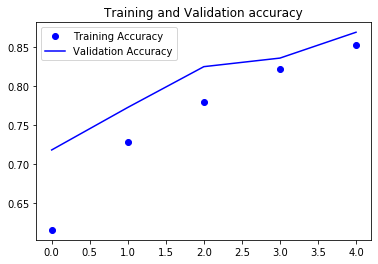

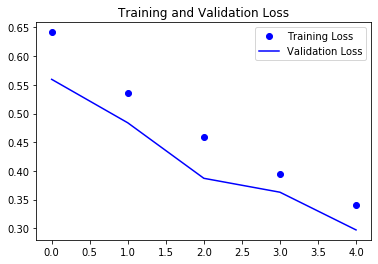

In [29]:
import matplotlib.pyplot as plt 

train_acc = trainer.train_acc_list
val_acc = trainer.val_acc_list 

train_loss = trainer.train_loss_list 
val_loss = trainer.val_loss_list 

train_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in train_loss]
val_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in val_loss]

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title("Training and Validation accuracy")
plt.legend() 
plt.figure() 

plt.plot(epochs, train_loss_np_list, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_np_list, 'b', label='Validation Loss') 
plt.title("Training and Validation Loss")
plt.legend() 
plt.show()


## Fine-tuning

Another widely used technique for model reuse, complementary to feature extraction, is _fine-tuning_. 
Fine-tuning consists in unfreezing a few of the top layers 
of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the 
fully-connected classifier) and these top layers. This is called "fine-tuning" because it slightly adjusts the more abstract 
representations of the model being reused, in order to make them more relevant for the problem at hand.

![fine-tuning VGG16](https://s3.amazonaws.com/book.keras.io/img/ch5/vgg16_fine_tuning.png)

We have stated before that it was necessary to freeze the convolution base of VGG16 in order to be able to train a randomly initialized 
classifier on top. For the same reason, it is only possible to fine-tune the top layers of the convolutional base once the classifier on 
top has already been trained. If the classified wasn't already trained, then the error signal propagating through the network during 
training would be too large, and the representations previously learned by the layers being fine-tuned would be destroyed. Thus the steps 
for fine-tuning a network are as follow:

* 1) Add your custom network on top of an already trained base network.
* 2) Freeze the base network.
* 3) Train the part you added.
* 4) Unfreeze some layers in the base network.
* 5) Jointly train both these layers and the part you added.

We have already completed the first 3 steps when doing feature extraction. Let's proceed with the 4th step: we will unfreeze our `conv_base`, 
and then freeze individual layers inside of it.

As a reminder, this is what our convolutional base looks like:

In [18]:
class Trainer(object):
    def __init__(self, batch_size, lr, checkname, pretrained):
        self.batch_size = batch_size
        self.lr = lr
        self.checkname = checkname
        self.pretrained = pretrained
        
        self.train_dataset = CustomDataset('train') 
        self.train_dataloader = torch.utils.data.DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle = True)
        self.val_dataset = CustomDataset('val')
        self.val_dataloader = torch.utils.data.DataLoader(self.val_dataset, batch_size = self.batch_size, shuffle = False)
        self.device = 'cuda'
        self.model = models.vgg16(pretrained=pretrained)
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        update_params_names = ['features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias','features.28.weight','features.28.bias']
        for name, param in self.model.named_parameters():
            if 'classifier' not in name and name not in update_params_names:
                param.requires_grad = False 
            else:
                param.requires_grad = True

        self.model = self.model.to(self.device)
        self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr=self.lr) 
        self.criterion = nn.CrossEntropyLoss()
        self.save_root = os.path.join('saved_model/dogs-vs-cats/ckpts', self.checkname)
        os.makedirs(self.save_root, exist_ok=True)
        self.best_pred = 0
        self.train_acc_list = []
        self.train_loss_list = []
        self.val_acc_list = []
        self.val_loss_list = []
        
    def training(self, epoch):
        self.model.train()
        self.total_loss = 0
        self.train_acc = 0
        total = 0
        for i, (img, label) in tqdm(enumerate(self.train_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            self.optimizer.zero_grad() 
            pred = self.model(img) 
            _, predicted = torch.max(pred.data, 1) 
            self.train_acc += (predicted==label).sum().item() 
            total += label.size(0)
            loss = self.criterion(pred, label)
            loss.backward() 
            self.optimizer.step() 
            self.total_loss += loss 
        self.train_acc_list.append(self.train_acc/total)
        self.train_loss_list.append(self.total_loss/(i+1))
        print('Training loss : %.5f'%(self.total_loss/(i+1)))
        print('Training Accuracy : %.5f'%(self.train_acc/total))
        
        
    def validation(self, epoch):
        self.model.eval() 
        self.val_loss = 0
        self.val_acc = 0
        total = 0 
        for i, (img, label) in tqdm(enumerate(self.val_dataloader)):
            img, label = img.to(self.device), label.to(self.device)
            with torch.no_grad():
                pred = self.model(img) 
                _, predicted = torch.max(pred.data,1) 
                
                self.val_acc += (predicted==label).sum().item() 
                total += label.size(0) 
                loss = self.criterion(pred, label) 
                self.val_loss += loss
                
        self.val_acc_list.append(self.val_acc/total) 
        self.val_loss_list.append(self.val_loss/(i+1))
        print('Validation loss : %.5f'%(self.val_loss/(i+1)))
        print('Validation accuracy : %.5f'%(self.val_acc/total))
              
        if self.val_acc/total > self.best_pred:
            self.best_pred = self.val_acc/total
            torch.save(self.model.state_dict(), os.path.join(self.save_root, 'model_best.pth'))


In [19]:
def fit(epochs, batch_size, lr, checkname, pretrained):
    trainer = Trainer(batch_size, lr, checkname, pretrained)
    for epoch in range(epochs):
        print('Epoch :', str(epoch))
        trainer.training(epoch) 
        trainer.validation(epoch)
    print('Best prediction on Validation set :', trainer.best_pred)
    return trainer

In [20]:
trainer = fit(5, 32, 2e-5, 'exp1', 0)   # If you want to train more, increase the epoch number 5.

Epoch : 0


625it [01:31,  6.85it/s]


Training loss : 0.13260
Training Accuracy : 0.95920


157it [00:21,  7.35it/s]


Validation loss : 0.05746
Validation accuracy : 0.97760
Epoch : 1


625it [01:32,  6.73it/s]


Training loss : 0.04861
Training Accuracy : 0.98175


157it [00:22,  7.06it/s]


Validation loss : 0.04995
Validation accuracy : 0.98080
Epoch : 2


625it [01:35,  6.57it/s]


Training loss : 0.02956
Training Accuracy : 0.98995


157it [00:22,  7.09it/s]


Validation loss : 0.05510
Validation accuracy : 0.98000
Epoch : 3


625it [01:35,  6.52it/s]


Training loss : 0.02289
Training Accuracy : 0.99205


157it [00:22,  6.85it/s]


Validation loss : 0.06116
Validation accuracy : 0.98200
Epoch : 4


625it [01:37,  6.42it/s]


Training loss : 0.01464
Training Accuracy : 0.99525


157it [00:22,  6.85it/s]


Validation loss : 0.06548
Validation accuracy : 0.98280
Best prediction on Validation set : 0.9828


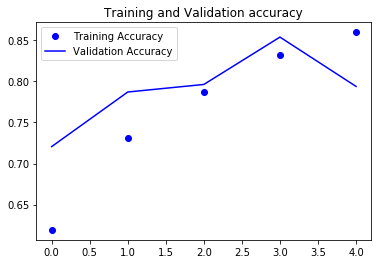

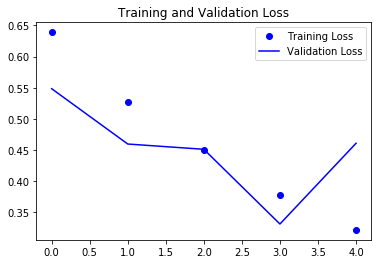

In [25]:

train_acc = trainer.train_acc_list
val_acc = trainer.val_acc_list 

train_loss = trainer.train_loss_list 
val_loss = trainer.val_loss_list

train_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in train_loss]
val_loss_np_list = [tensor_loss.cpu().detach().numpy() for tensor_loss in val_loss]

epochs = range(len(train_acc))
plt.plot(epochs, train_acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy') 
plt.title("Training and Validation accuracy")
plt.legend() 
plt.figure() 

plt.plot(epochs, train_loss_np_list, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_np_list, 'b', label='Validation Loss') 
plt.title("Training and Validation Loss")
plt.legend() 
plt.show()


### Inference on Test dataset (Visualize)

In [30]:
class Inferer():
    def __init__(self, exp):
        self.model = models.vgg16()
        self.num_classes = 2
        self.model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=self.num_classes, bias=True)
        self.saved_model_path = 'saved_model/dogs-vs-cats'
        self.ckpt = torch.load(os.path.join(self.saved_model_path, exp, 'model_best.pth'))
        self.model.load_state_dict(self.ckpt) 
        self.model = self.model.to('cuda') 
    
        self.test_list = os.listdir('data/datasets/dogs-vs-cats/val')
        random.shuffle(self.test_list)
        self.img_trans = transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),])
        self.label_dict = {0:'cat', 1:'dog'}
        self.model.eval()
    
    def infer(self): 
        for item in self.test_list[:10]:
            tgt = os.path.join(self.test_root, item)
            PIL_img = Image.open(tgt)
            img = self.img_trans(PIL_img)
            img = img.unsqueeze(0).cuda()
            output = self.model(img) 
            _, predicted = torch.max(output,1)
            plt.axis("off")
            plt.imshow(PIL_img) 
            print('Prediction :', self.label_dict[predicted.item()])
            plt.show()

Prediction : dog


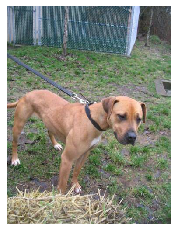

Prediction : dog


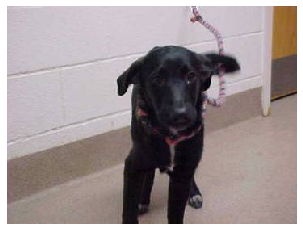

Prediction : cat


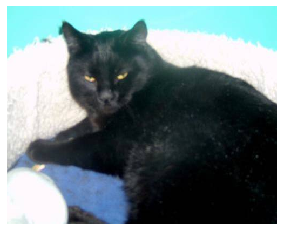

Prediction : dog


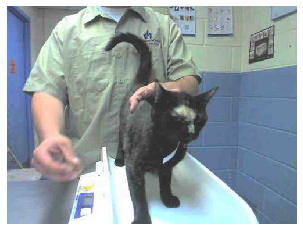

Prediction : dog


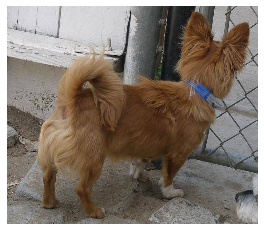

Prediction : dog


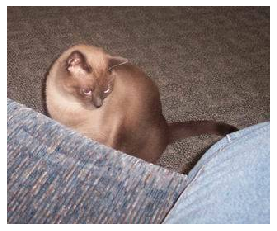

Prediction : cat


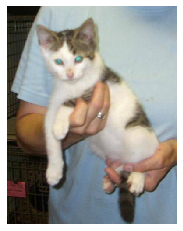

Prediction : cat


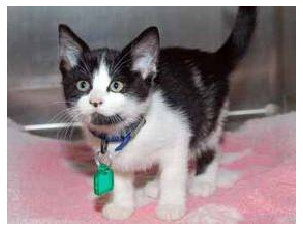

Prediction : cat


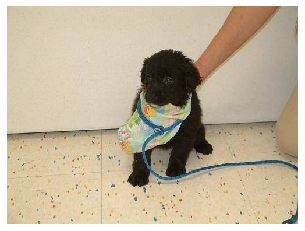

Prediction : cat


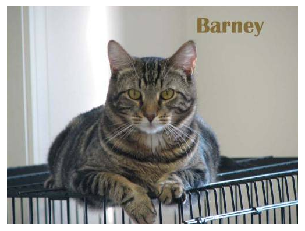

Best prediction on Validation set : 0.7688


In [31]:
infer_exp1 = Inferer('exp1')
infer_exp1.infer()